In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import make_classification

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def oneHotEncode(df, sentiment=True, event=True):
    onehot_encoder = OneHotEncoder(sparse=False)
    
    if sentiment:
        column = df['sentiment'].values.reshape(-1, 1)
        column_encoded = onehot_encoder.fit_transform(column)
        encoded_df = pd.DataFrame(column_encoded, columns=onehot_encoder.get_feature_names(['sentiment']))
        df = pd.concat([df, encoded_df], axis=1)
        df = df.drop(columns=['sentiment'])
    
    if event:
        column = df['event'].values.reshape(-1, 1)
        column_encoded = onehot_encoder.fit_transform(column)
        encoded_df = pd.DataFrame(column_encoded, columns=onehot_encoder.get_feature_names(['event']))
        df = pd.concat([df, encoded_df], axis=1)
        df = df.drop(columns=['event'])

    return df


def getAccuracy(df):
    """
    A predicted BUY (SELL) should be classified as correct if the stock 
    price increases (decreases), even if the labelled action is HOLD
    """
    correct = 0
    
    for index, row in df.iterrows():
        if row['prediction'] == row['action']:
            correct += 1
        elif row['prediction'] == 'BUY' and row['price_change_percent'] > 0:
            correct += 1
        elif row['prediction'] == 'SELL' and row['price_change_percent'] < 0:
            correct += 1
            
    accuracy = correct / len(df)

    return accuracy

In [3]:
data = pd.read_csv('new2_current_progress_labelled.csv')
data = oneHotEncode(data, sentiment=False)

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
event_cols = [col for col in data.columns if col.startswith('event')]

X_train = train_data[event_cols]
y_train = train_data[['action']]
X_test = test_data[event_cols]
y_test = test_data[['action']]

### Event Model

In [4]:
eventModel = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
eventModel.fit(X_train, y_train)

y_pred = eventModel.predict(X_test)

test_data['prediction'] = y_pred

getAccuracy(test_data)

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/tmp/ipykernel_2430098/4063468451.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = y_pred


0.4830917874396135

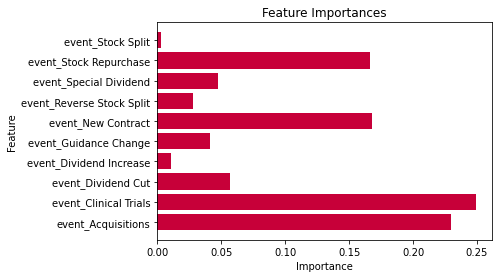

In [5]:
# create a horizontal bar chart of feature importances
plt.barh(X_train.columns, eventModel.feature_importances_, color='#C70039')

# add axis labels and title
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')

# display the plot
plt.show()


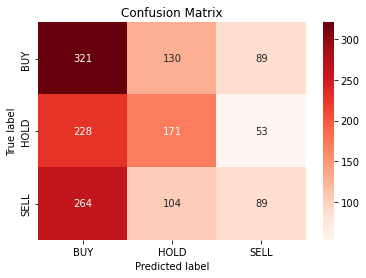

In [6]:
cm = confusion_matrix(test_data['action'], test_data['prediction'])

cm_df = pd.DataFrame(cm, columns=['BUY', 'HOLD', 'SELL'], index=['BUY', 'HOLD', 'SELL'])

# create heatmap using seaborn library
sns.heatmap(cm_df, annot=True, cmap='Reds', fmt='d')

plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### Sentiment Model

In [7]:
data = pd.read_csv('current_sentiment_labelled-temp.csv')
data = oneHotEncode(data, event=False)

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

sentiment_cols = [col for col in data.columns if col.startswith('sentiment')]

X_train = train_data[sentiment_cols]
y_train = train_data[['action']]
X_test = test_data[sentiment_cols]
y_test = test_data[['action']]

In [359]:
data = pd.read_csv('current_sentiment_labelled.csv')
data = oneHotEncode(data, event=False)

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

sentiment_cols = [col for col in data.columns if col.startswith('sentiment')]

X_train = train_data[sentiment_cols]
y_train = train_data[['action']]
X_test = test_data[sentiment_cols]
y_test = test_data[['action']]

In [268]:
data[data['sentiment'] == 'negative']['action'].value_counts()

SELL    94
BUY     70
HOLD    54
Name: action, dtype: int64

In [325]:
sentimentModel = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
sentimentModel.fit(X_train, y_train)

y_pred = sentimentModel.predict(X_test)

test_data['prediction'] = y_pred

getAccuracy(test_data)

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/tmp/ipykernel_385717/3490689924.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = y_pred


0.45345345345345345

In [296]:
sentimentModel.feature_importances_

array([0.12761133, 0.05375164, 0.81863703])

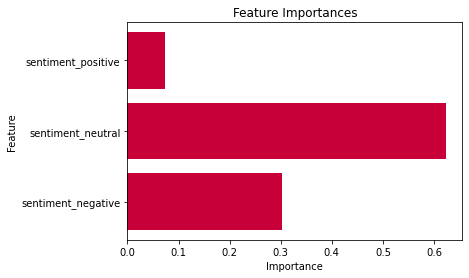

In [360]:
# create a horizontal bar chart of feature importances
plt.barh(X_train.columns, sentimentModel.feature_importances_, color='#C70039')

# add axis labels and title
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')

# display the plot
plt.show()

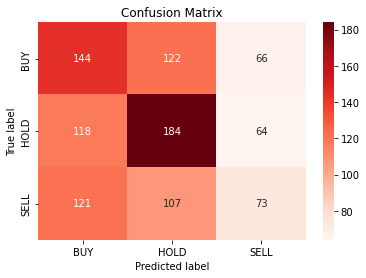

In [313]:
cm = confusion_matrix(test_data['action'], test_data['prediction'])

cm_df = pd.DataFrame(cm, columns=['BUY', 'HOLD', 'SELL'], index=['BUY', 'HOLD', 'SELL'])

# create heatmap using seaborn library
sns.heatmap(cm_df, annot=True, cmap='Reds', fmt='d')

plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [306]:
test_data['prediction'].value_counts()

BUY     378
HOLD    339
SELL    202
Name: prediction, dtype: int64

In [205]:
data = pd.read_csv('current_sentiment_labelled-temp.csv')
data['sentiment'].value_counts()

neutral     6441
positive    3326
negative     233
Name: sentiment, dtype: int64

In [206]:
data = pd.read_csv('current_sentiment_labelled-temp.csv')

In [207]:
data['sentiment'].value_counts()

positive    3326
neutral     3000
negative     233
Name: sentiment, dtype: int64

In [287]:
class SentimentModel(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        return self
    
    def predict(self, X):
        results = []
        for index, row in X.iterrows():
            if row['sentiment_positive'] == 1:
                results.append('BUY')
            elif row['sentiment_negative'] == 1:
                results.append('SELL')
            else:
                results.append('HOLD')
        return results

In [288]:
sentModel = SentimentModel()
sentModel.fit(X_train, y_train)

y_pred = sentModel.predict(X_test)
test_data['prediction'] = y_pred

getAccuracy(test_data)

/tmp/ipykernel_385717/540730962.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = y_pred


0.39173967459324155

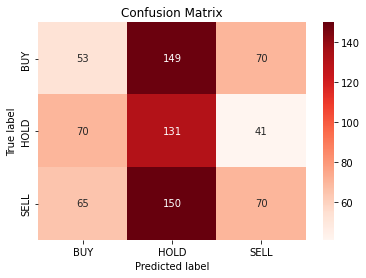

In [289]:
cm = confusion_matrix(test_data['action'], test_data['prediction'])

cm_df = pd.DataFrame(cm, columns=['BUY', 'HOLD', 'SELL'], index=['BUY', 'HOLD', 'SELL'])

# create heatmap using seaborn library
sns.heatmap(cm_df, annot=True, cmap='Reds', fmt='d')

plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### Ensemble Model

In [357]:
data = pd.read_csv('new2_current_progress_labelled.csv')
data = oneHotEncode(data)

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

event_cols = [col for col in data.columns if col.startswith('event')]
sentiment_cols = [col for col in data.columns if col.startswith('sentiment')]

X_train = train_data[event_cols + sentiment_cols]
y_train = train_data[['action']]
X_test = test_data[event_cols + sentiment_cols]
y_test = test_data[['action']]

In [335]:
data = pd.read_csv('new2_current_progress_labelled.csv')

#### Stacking Model

In [308]:
class StackingModel:
    
    def __init__(self, base_models, meta_model, cols):
        self.base_models = base_models
        self.meta_model = meta_model
        self.cols = cols
        
    def _oneHotEncode(self, df):
        onehot_encoder = OneHotEncoder(sparse=False)

        column = df['event'].values.reshape(-1, 1)
        column_encoded = onehot_encoder.fit_transform(column)
        encoded_df = pd.DataFrame(column_encoded, columns=onehot_encoder.get_feature_names(['event']))
        df = pd.concat([df, encoded_df], axis=1)
        df = df.drop('event', axis=1)

        column = df['sentiment'].values.reshape(-1, 1)
        column_encoded = onehot_encoder.fit_transform(column)
        encoded_df = pd.DataFrame(column_encoded, columns=onehot_encoder.get_feature_names(['sentiment']))
        df = pd.concat([df, encoded_df], axis=1)
        df = df.drop('sentiment', axis=1)

        return df
        
    def fit(self, X, y):
#         base_model_preds = np.zeros((X.shape[0], len(self.base_models)))
        base_model_preds = np.empty((X.shape[0], len(self.base_models)), dtype=str)
        base_preds = []
        for i, model in enumerate(self.base_models):
#             model.fit(X[self.cols[i]], y)
            y_pred = model.predict(X[self.cols[i]])
            base_preds.append(y_pred)
        
        base_preds = pd.DataFrame({'event': base_preds[0], 'sentiment': base_preds[1]})
        base_preds = self._oneHotEncode(base_preds)
        print(base_preds.columns)
        self.meta_model.fit(base_preds, y)
    
    def predict(self, X):
#         base_model_preds = np.empty((X.shape[0], len(self.base_models)), dtype=str)
        base_preds = []
        for i, model in enumerate(self.base_models):
            y_pred = model.predict(X[self.cols[i]])
            base_preds.append(y_pred)
        
        base_preds = pd.DataFrame({'event': base_preds[0], 'sentiment': base_preds[1]})
        base_preds = self._oneHotEncode(base_preds)
            
        return self.meta_model.predict(base_preds)


In [358]:
le = LabelEncoder()
y_train_numeric = pd.DataFrame()
y_train_numeric['action'] = le.fit_transform(train_data['action'])

meta_model = LogisticRegression(random_state=42, multi_class='multinomial', solver='lbfgs')
meta_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
stacking_model = StackingModel([eventModel, sentimentModel], meta_model, [event_cols, sentiment_cols])
stacking_model.fit(X_train, y_train)

y_pred = stacking_model.predict(X_test)

test_data['prediction'] = y_pred

getAccuracy(test_data)

Index(['event_BUY', 'event_HOLD', 'event_SELL', 'sentiment_BUY',
       'sentiment_HOLD', 'sentiment_SELL'],
      dtype='object')


/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/tmp/ipykernel_385717/2923594261.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = y_pred


0.4925266903914591

In [180]:
meta_model.feature_importances_

array([0.05298741, 0.81071758, 0.06789613, 0.0083338 , 0.05832604,
       0.00173904])

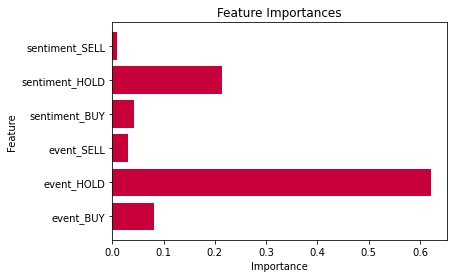

In [342]:
# create a horizontal bar chart of feature importances
plt.barh(['event_BUY', 'event_HOLD', 'event_SELL', 'sentiment_BUY',
       'sentiment_HOLD', 'sentiment_SELL'], meta_model.feature_importances_, color='#C70039')

# add axis labels and title
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')

# display the plot
plt.show()

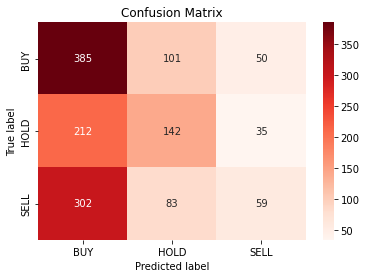

In [343]:
cm = confusion_matrix(test_data['action'], test_data['prediction'])

cm_df = pd.DataFrame(cm, columns=['BUY', 'HOLD', 'SELL'], index=['BUY', 'HOLD', 'SELL'])

# create heatmap using seaborn library
sns.heatmap(cm_df, annot=True, cmap='Reds', fmt='d')

plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [194]:
sent_data = pd.read_csv('current_sentiment_labelled-temp.csv')
sent_data['sentiment'].value_counts()